## Введение в анализ данных, ИАД-1

## НИУ ВШЭ, 2018-19 учебный год

###  Домашнее задание №3. Обработка текстов. Линейная классификация.

Задание выполнил(а): _Самоделкина Мария_

### Общая информация
__Дата выдачи:__ 28.04.2019

__Дедлайн:__ 23:59 12.05.2019

### Оценивание и штрафы

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 балл в день, но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи
__Стирать условия нельзя!__

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/).

Формат названия файла: homework_03_Фамилия_Имя.ipynb

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

В задании вам предоставлены реальные текстовые данные. 

Необходимо построить алгоритм, который будет по тексту документа определять тип источника:
 - Микроблоги
 - Новости
 - Отзывы
 - Форумы
 - Блоги
 - Видео
 - Мессенджеры

## Часть 1. Работа с текстовыми данными

 ### 1. Исследование данных

[2 балла]

Скачаем данные отсюда:
https://yadi.sk/d/o3cPgFAq5gALiw

In [2]:
D = pd.read_csv('texts_dataset.csv', sep=';', index_col=0)

C:\Users\Pro18\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
D.head()

,Дата,ID сообщения,Заголовок,Текст,Дублей,Тип источника
0,27.04.2019 13:18,1396238,NaN,"-Здравствуйте, тинькофф банк\n-Мать твою ебал\...",1.0,Микроблоги
1,27.04.2019 13:15,1396239,NaN,Почему Немагия сделала обзор на Тинькова? #нем...,1.0,Микроблоги
2,27.04.2019 13:10,1396248,Forbes назвал самые экстравагантные инвестиции...,"13:01, 27.04.2019 \n\nПоделиться:\n\n \n 57 ...",2.0,Новости
3,27.04.2019 13:06,1396243,Forbes назвал самые экстравагантные инвестиции...,"13:01, 27.04.2019 \n\nПоделиться:\n\n \n 44 ...",2.0,Новости
4,27.04.2019 13:03,1396186,Тинькофф Страхование: Не купить полис без подп...,Первый отзыв без оценки:&nbsp;\nhttps://www.ba...,1.0,Отзывы


Далее будем использовать лишь поля  "Текст", "Тип источника"

In [4]:
D = D[[ "Текст", "Тип источника"]]

In [5]:
D.head()

,Текст,Тип источника
0,"-Здравствуйте, тинькофф банк\n-Мать твою ебал\...",Микроблоги
1,Почему Немагия сделала обзор на Тинькова? #нем...,Микроблоги
2,"13:01, 27.04.2019 \n\nПоделиться:\n\n \n 57 ...",Новости
3,"13:01, 27.04.2019 \n\nПоделиться:\n\n \n 44 ...",Новости
4,Первый отзыв без оценки:&nbsp;\nhttps://www.ba...,Отзывы


In [6]:
for i in D['Тип источника'].unique():
    print (i)

Микроблоги
Новости
Отзывы
Форумы
Блоги
Видео
Мессенджеры
nan


In [7]:
D.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200206 entries, 0 to 200205
Data columns (total 2 columns):
Текст            199578 non-null object
Тип источника    199993 non-null object
dtypes: object(2)
memory usage: 4.6+ MB


Удалим объекты с пропусками

In [8]:
D.dropna(axis = 0, inplace=True)

#### 1.1 Выведите среднюю длину текстов в каждом классе. Что можно сказать о данных? Что можно сказать о каждом классе?

In [9]:
lenth = {}
for index, row in D.iterrows():
    one = row['Тип источника']
    text = row['Текст']
    if one in lenth: 
        lenth[one] += len(text) 
    else: 
        lenth[one] = len(text) 

for one in lenth:
    print (one, lenth.get(one) / D[(D['Тип источника'] == one)]['Тип источника'].count())

Микроблоги 170.06141040462427
Новости 2602.3423206042803
Отзывы 550.4785651967005
Форумы 462.227363457533
Блоги 3490.84946848899
Видео 905.1847899159663
Мессенджеры 943.7823968821045


Получили, что данные в каждом классе достаточно разнородные. Тексты из класса 'Блоги' будут большими (в среднем пости 3,5 тыс. символов). Это объяснимо, ведь в 'Блогах' чаще содержатся длинные тексты. Класс 'Новости' содержит менее объемные тексты, всего 2,6 тысячи символов. Новости не должны быть ни слишком объемными, ни слишком короткими. 'Видео' и 'Мессенджеры' содержат тексты средней длины, чусть меньше 1 тыс., что является ожидаемой средней длиной для текстов такого типа.  В 'Отзывах' и 'Форумах' в среднем около 500 символов, скорее всего там содержатся короткие комментарии. В 'Микроблогах' меньше всего символов: вероятно, там находятся короткие высказываения и сообщения.

#### 1.2 Приведите тексты к нижнему регистру и токенезируйте их

используйте word_tokenize из nltk.tokenize

In [10]:
import nltk
from nltk.tokenize import word_tokenize
D['tokenTexts'] = D.apply(lambda x: x['Текст'].lower(), axis=1)
D['tokenTexts'] = D.apply(lambda x: word_tokenize(x['tokenTexts']), axis=1)

#### 1.3 Оставьте в каждом документе токены содержащие  только буквы русского или английского алфавита.


In [11]:
D['tokenTexts'] = D.apply(lambda x: [w for w in x['tokenTexts'] if w.isalpha()], axis=1)

In [12]:
#проверим, как получилось
D['tokenTexts'].head()

0             [тинькофф, банк, твою, ебал, досвидания]
1    [почему, немагия, сделала, обзор, на, тинькова...
2    [поделиться, forbes, назвал, самые, экстравага...
3    [поделиться, forbes, назвал, самые, экстравага...
4    [первый, отзыв, без, оценки, nbsp, https, крат...
Name: tokenTexts, dtype: object

#### 1.4 Выведите 20 слов, которые встечаются в наибольшем числе документов. Что можно сказать об этих словах?

In [13]:
import collections
a = collections.Counter()
for text in D.tokenTexts:
    for word in set(text):
        if word in a: 
            a[word] += 1 
        else: 
            a[word] = 1

print (*a.most_common(20), sep = "\n")

('в', 144033)
('и', 136262)
('на', 117638)
('не', 110081)
('тинькофф', 105112)
('с', 100489)
('банк', 93858)
('по', 84583)
('что', 82808)
('а', 71779)
('за', 68298)
('банка', 62513)
('как', 60769)
('это', 59170)
('у', 55321)
('для', 55128)
('так', 50070)
('от', 49675)
('но', 47131)
('к', 45944)


Ожидаемо, что предлоги и союзы будут одними из самых часто встречаемых слов. Причем у слов "в", "и", "на", "не" достаточно большой отрыв в количестве встреваемости в отличие от других слов. Также популярны слова "банк", "банка" и "тинькофф", что говорит о том, что тексты из какой-то финансовой сферы.

#### 1.5 Выведите 20 слов, которые встечаются в наименьшем числе документов 

In [14]:
print (*a.most_common()[-20:], sep = "\n")

('вардер', 1)
('охеренный', 1)
('фейсу', 1)
('jagger', 1)
('устанлвлено', 1)
('психую', 1)
('вылазящий', 1)
('кэшбжком', 1)
('повалится', 1)
('отреклось', 1)
('netesov', 1)
('сварганили', 1)
('кредитчику', 1)
('выписного', 1)
('наличгыми', 1)
('pandeglol', 1)
('пэйпассу', 1)
('заказывый', 1)
('советсткую', 1)
('сверкало', 1)


### 2. Подготовка данных

[3 балла]

####  2.1 Разделите выборку на обучающую и тестовую в соотношении 70:30

In [15]:
X = [' '.join([w for w in t]) for t in  D['tokenTexts']]
y = D['Тип источника']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=0.3)

#### 2.2 Обучите BOW векторы на обучающей выборке и примените преобразование к обучающей и тестовой

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
cnt_vec = CountVectorizer()
X_train_BOW = cnt_vec.fit_transform(X_train)
X_test_BOW = cnt_vec.transform(X_test)

#### 2.3 Обучите TFIDF векторы на обучающей выборке и примените преобразование к тестовой

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
X_train_TFIDF = tfidf_vec.fit_transform(X_train)
X_test_TFIDF = tfidf_vec.transform(X_test)

#### 2.4 Примените стемминг к текстам обучающей и тестовой выборки. Обучите TFIDF векторы на полученных данных.

In [18]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('russian')
X_train_stem = [[stemmer.stem(w) for w in t.split(" ")] for t in X_train]
X_test_stem = [[stemmer.stem(w) for w in t.split(" ")] for t in X_test]

In [19]:
X_train_stem = [" ".join(t) for t in X_train_stem]
X_test_stem = [" ".join(t) for t in X_test_stem]

In [20]:
tfidf_vec1 = TfidfVectorizer()
X_train_STEM = tfidf_vec1.fit_transform(X_train_stem)
X_test_STEM = tfidf_vec1.transform(X_test_stem)

#### 2.5 Сравните размеры полученных матриц

In [21]:
print("BOW matrix:",X_train_BOW.shape, X_test_BOW.shape)
print("TFIDF matrix:",X_train_TFIDF.shape, X_test_TFIDF.shape)
print("TFIDF&STEM matrix:",X_train_STEM.shape, X_test_STEM.shape)

BOW matrix: (139697, 277420) (59871, 277420)
TFIDF matrix: (139697, 277420) (59871, 277420)
TFIDF&STEM matrix: (139697, 123239) (59871, 123239)


У матрицы со стеммингом размер меньше, так как некотороые слова при стемминге стали одинаковыми.

### 3. Обучение модели и оценка результатов

[2 балла]

#### 3.1 Обучите логистическую регрессию SGDClassifier на данных, полученных в пунктах 2.2, 2.3 и 2.4.
#### Оцените качество на отложенной выборке по метрике accuracy

In [76]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
sgdc_BOW = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
sgdc_BOW.fit(X_train_BOW, y_train)
predict_BOW = sgdc_BOW.predict(X_test_BOW)

In [77]:
sgdc_TFIDF = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
sgdc_TFIDF.fit(X_train_TFIDF, y_train)
predict_TFIDF = sgdc_TFIDF.predict(X_test_TFIDF)

In [78]:
sgdc_STEM = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
sgdc_STEM.fit(X_train_STEM, y_train)
predict_STEM = sgdc_STEM.predict(X_test_STEM)

In [79]:
print('BOW accuracy:', accuracy_score(y_test,predict_BOW))
print('TFIDF accuracy:', accuracy_score(y_test,predict_TFIDF))
print('TFIDF&STEM accuracy:', accuracy_score(y_test,predict_STEM))

BOW accuracy: 0.8446827345459405
TFIDF accuracy: 0.8345943779125119
TFIDF&STEM accuracy: 0.8243389955070067


#### 3.2 Какой алгоритм показал наилучшее качество классификации? Как это можно объяснить?

Доля правильных ответов больше для BOW векторов. Это можно объяснить тем, что нам оказался важнее просто набор независимых слов.
TFIDF предлагает веса для каждого слова, что в данном случае, видимо, не является необходимым. 
При стемминге моддель могла обрезать что-то важное и недообучиться.

#### 3.3 Выведите несколько документов из тестовой выборки, на которых были допущены ошибки. Что можно о них сказать?

In [198]:
mask = (y_test != predict_BOW).tolist()
mask
np.array(X_test)[mask][:10]

array(['лет назад взяли кредит на отдавали в течении лет по в месяц давным давно должны были закрыть отдавали через почту квитанций не осталось сейчас банк требует с нас за задержки в течении лет ведем суд банк на запросы не отвечает не выдает ни договора о кредите ни историю платежей сегодня арестовали счет в сбербанке посоветуйте что можно предпринять в такой ситуации',
       'какие платежные инструменты придут на смену традиционным банковским картам глава сбербанка герман греф пророчит смерть пластиковых карточек уверен что после года на смену пластику придут системы биометрической идентификации клиентов действительно ли мир откажется от карточек какие платежные инструменты придут им на смену этот вопрос редакция решила обсудить с участниками рынка марат абасалиев директор атол онлайн платежи будут совершаться с помощью отпечатка пальца или сетчатки глаза банковским карточкам на смену придут другие способы доступа к деньгам на счете но клиринговая инфраструктура останется прежней т

Про данные текты действительно нельзя точно сказать, к какому классу они могут осноситься, возникают сложности с определением их типа. Тексты непонятны, иногда не содержательны.

#### 3.4 Постройте матрицу ошибок. Проанализируйте ее.

In [110]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, predict_BOW, 
                               labels=["Микроблоги", "Новости", "Отзывы", "Форумы", "Блоги", "Видео", "Мессенджеры"])
conf_matrix = pd.DataFrame(conf_matrix, 
                           columns=['Predicted: Микроблоги', 'Predicted: Новости', 'Predicted: Отзывы', 'Predicted: Форумы', 'Predicted: Блоги', 'Predicted: Видео', 'Predicted: Мессенджеры'], 
                           index=['Actual: Микроблоги', 'Actual: Новости', 'Actual: Отзывы', 'Actual: Форумы', 'Actual: Блоги', 'Actual: Видео', 'Actual: Мессенджеры'])
conf_matrix

,Predicted: Микроблоги,Predicted: Новости,Predicted: Отзывы,Predicted: Форумы,Predicted: Блоги,Predicted: Видео,Predicted: Мессенджеры
Actual: Микроблоги,5522,0,251,468,0,136,3
Actual: Новости,167,9883,283,721,130,166,74
Actual: Отзывы,90,72,13591,1398,25,58,6
Actual: Форумы,274,168,1851,18120,42,251,38
Actual: Блоги,58,427,148,338,452,96,49
Actual: Видео,318,15,237,470,7,2551,16
Actual: Мессенджеры,174,49,28,140,13,54,443


Видно, что большая часть ответов дана правильно. Классификатор совсем не путает предсказание "Новости" и "Блоги" с "Микроблогами". Модель часто путает "Форумы" с чем-то еще. Много путаницы между "Отзывами" и "Форумами". На остальных ошибается не часто. 

## Часть 2. Логистическая регрессия.
[3 балла]

Для наших экспериентов возьмём обучающую выборку [отсюда](https://www.kaggle.com/iabhishekofficial/mobile-price-classification).

In [52]:
train = pd.read_csv('train.csv')

In [53]:
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Решается задача многоклассовой классификации — определение ценовой категории телефона. Для простоты перейдём к задаче бинарной классификации — пусть исходные классы 0 и 1 соответствуют классу 0 новой целевой переменной, а остальные классу 1.
​
Замените целевую переменную, отделите её в отдельную переменную и удалите из исходной выборки.

In [54]:
target = train['price_range'].apply(lambda x: 0 if x == 0 or x == 1 else 1)
del train['price_range']

Разделите выборку на обучающую и тестовую части в соотношении 7 к 3. Для этого можно использовать `train_test_split` из scikit-learn. Не забудьте зафиксировать сид для разбиения.

In [55]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(train, target, random_state=13, test_size=0.3)

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

Не забывайте, что для линейных методов матрицу объекты-признаки необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из способов). Для этого можно воспользоваться `StandardScaler` или сделать это вручную.

In [56]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X1_train = sc.fit_transform(X1_train)
X1_test = sc.transform(X1_test)

C:\Users\Pro18\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Pro18\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Pro18\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


Обучите логистическую регрессию. Сделайте предсказания для тестовой части, посчитайте по ним ROC-AUC и Accuracy (порог 0.5). Хорошо ли удаётся предсказывать целевую переменную?
Не забывайте, что метод predict_proba вычисляет вероятности обоих классов выборки, а в бинарной классификации нас интересует в первую очередь вероятность принадлежности к положительному классу.

In [57]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs').fit(X1_train, y1_train)
predict = lr.predict_proba(X1_test)[:,1]

In [58]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, precision_recall_curve
print('LogisticRegression ROC-AUC:', roc_auc_score(y1_test,predict))
print('LogisticRegression accuracy:', accuracy_score(y1_test,predict.round()))

LogisticRegression ROC-AUC: 0.9995444241966309
LogisticRegression accuracy: 0.9883333333333333


Предсказания получаются очень хорошими.

У обученной логистической регрессии есть два аттрибута: `coef_` и `intercept_`, которые соответствуют весам $w$ и $w_0$. Это и есть результат обучения логистической регрессии. Попробуйте с помощью них (с помощью всё той же обученной ранее логистической регрессии) посчитать "сырое" предсказание алгоритма $b(x)$. 

Постройте гистограмму полученных значений и ответьте на вопросы:
- Какие значения принимает такое предсказание?
- Похожи ли эти значения на вероятность классов?

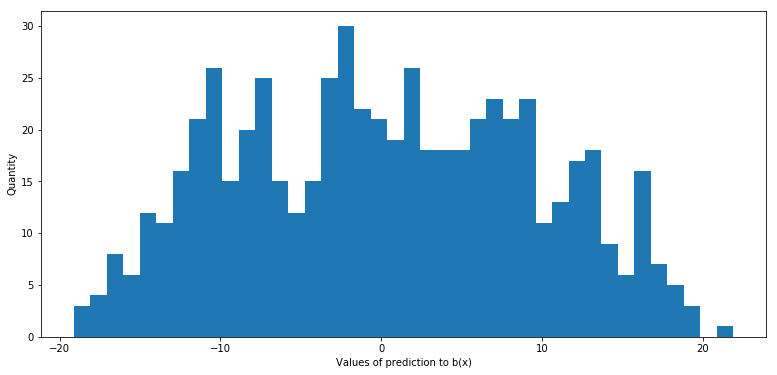

In [59]:
predict1 = lr.intercept_ + X1_test.dot(lr.coef_.T)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(13, 6))
plt.hist(predict1, bins = 40)
plt.xlabel('Values of prediction to b(x)')
plt.ylabel('Quantity');

Наше предсказание принмает значения в диапазоне от -20 до +20. Классификатор будет возвращать знак от предсказания. Чем больше по модулю значение предсказания, тем больше классификатор будет уверен в правильности ответа. С помощью этого действительно можно предсказать вероятность правильности ответа (если отнормировать предсказание - поделить на норму весов).

Реализуйте сигмоиду и постройте её график. Что вы можете сказать об этой функции?

Text(0.5, 1.0, 'Sigmoid Function')

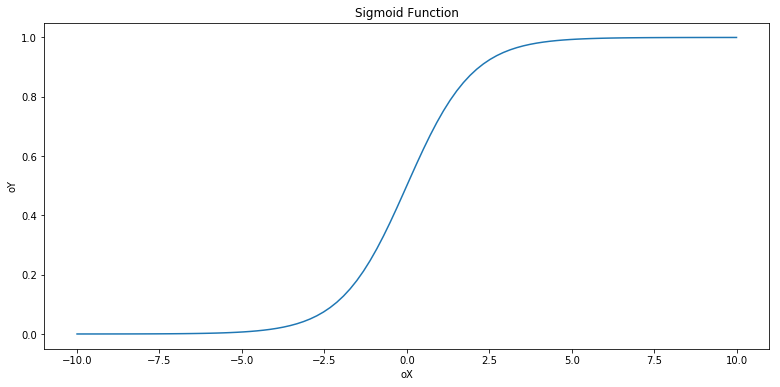

In [60]:
p = lambda x: 1 / (1 + np.exp(-x))
x = np.linspace(-10,10,100)
plt.figure(figsize=(13, 6))
plt.plot(x, p(x))
plt.xlabel('oX')
plt.ylabel('oY')
plt.title('Sigmoid Function')

Сигмоида подходит для оценки вероятности классов. При -infinity ее значение стремится к 0, при +infinity к 1.

Примените реализованную сигмоиду к $b(x)$. Вы должны получить вероятности принадлежности к положительному классу. Проверьте, что ваши значения совпали с теми, которые получены с помощью `predict_proba`.

In [61]:
p(predict1).ravel() == predict

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

Таким образом, обучение логистической регрессии — настройка параметров $w$ и $w_0$, а применение — подсчёт вероятностей принадлежности положительному классу как применение сигмоды к скалярному произведению признаков и параметров.

Постройте для обученной логистической регрессии ROC-кривую `roc_curve` и PR-кривую `precision_recall_curve`.

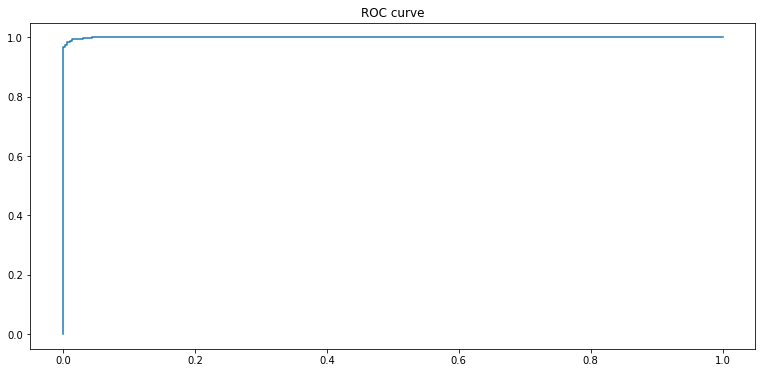

In [62]:
fpr, tpr, _ = roc_curve(y1_test,  predict)
auc = roc_auc_score(y1_test, predict)
plt.figure(figsize=(13, 6))
plt.plot(fpr,tpr)
plt.title('ROC curve')
plt.show()

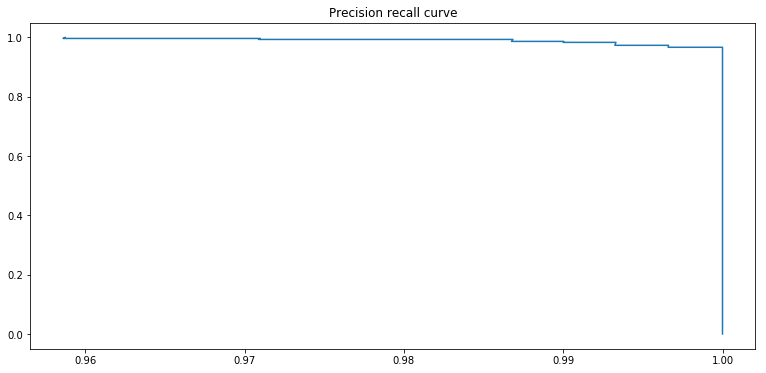

In [63]:
precision, recall, _ = precision_recall_curve(y1_test, predict)
plt.figure(figsize=(13, 6))
plt.plot(precision,recall)
plt.title('Precision recall curve')
plt.show()

### 4. Бонусное задание. Обучение логистической регрессии.

[2 бонусных балла]

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$



Если выше вручную мы только применяли логистическую регрессию, то здесь предлагается реализовать обучение с помощью полного градиентного спуска.
Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.
Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково.

В качестве критерия останова необходимо использовать (одновременно):

- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Реализуйте обучение логистической регрессии. Для удобства ниже предоставлен прототип с необходимыми методами. В loss_history необходимо сохранять вычисленное на каждой итерации значение функции потерь.

In [64]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, lambda_2=10.0, tolerance=1e-4, max_iter=1000, alpha=0.01):
        """
        lambda_2: L2 regularization param
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        alpha: learning rate
        """
        self.lambda_2 = lambda_2
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.alpha = alpha
        self.w = None
        self.loss_history = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        self.w = np.random.rand(X.shape[1]) * 4 - 2
        for i in range(self.max_iter):
            x = self.w - self.alpha * self.calc_gradient(X, y)
            self.loss_history.append(self.calc_loss(X, y))
            if np.linalg.norm(self.w - x) < self.tolerance:
                self.w = x
                break
            self.w = x
        self.loss_history.append(self.calc_loss(X, y))
        return self
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        predict = 1 / (1 + np.exp(-X.dot(self.w.T)))
        return np.array((1 - predict, predict))
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        grad = np.zeros(X.shape[1])
        for i in range(0, y.shape[0]):
            grad +=  y.values[i]*X[i] / (1 + np.exp(-y.values[i] * X[i].dot(self.w.T))) 
        grad /= y.shape[0]
        grad -= self.lambda_2 * self.w
        return -grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        loss = 0
        for i in range(0, y.shape[0]):
            loss += np.log(1 + np.exp(-y.values[i] * X[i].dot(self.w.T)))
        loss /= y.shape[0]
        loss += 0.5 * self.lambda_2 * pow(np.linalg.norm(self.w), 2)
        return loss

- Примените логистическую регресиию на той же выборке.
- Посчитайте качество по тем же метрикам.
- Визуализируйте изменение значений функции потерь от номера итераций.

In [65]:
lr1 = LogReg()
lr1.fit(X1_train, y1_train)

LogReg(alpha=0.01, lambda_2=10.0, max_iter=1000, tolerance=0.0001)

In [66]:
predict_lr = lr1.predict_proba(X1_test)[1]
print('LogisticRegression ROC-AUC:', roc_auc_score(y1_test,predict_lr))
print('LogisticRegression accuracy:', accuracy_score(y1_test,predict_lr.round()))

LogisticRegression ROC-AUC: 0.9923885506022491
LogisticRegression accuracy: 0.9516666666666667


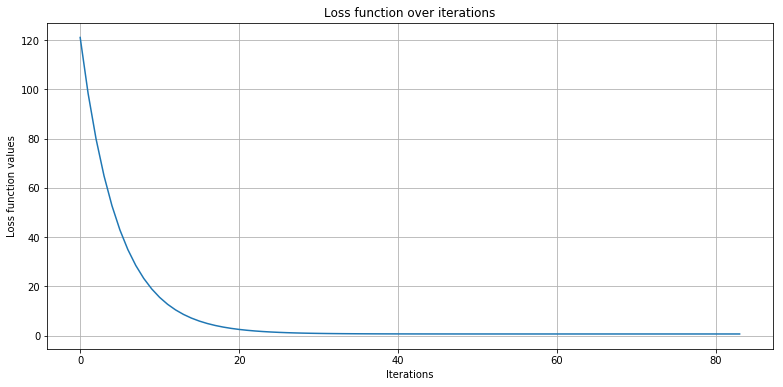

In [67]:
plt.figure(figsize=(13, 6))
plt.plot(range(len(lr1.loss_history)), lr1.loss_history)
plt.title('Loss function over iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss function values')
plt.grid()
plt.show()

### 5. Бонусное задание 2. 

[0.002 бонусных балла]

Напишите свой любимый текстовый (у нас же домашнее задание про тексты, ощущаете иронию) мем или анекдот

несколько твитов неизвестного автора. 
первый: "поскольку многие компании перед приемом на работу просматривают профили кандидата в социальных сетях, я буду ненавязчиво включать в твиты фрагменты своего резюме".
второй: "выпил сегодня апельсинового сока и это было отлично! почти так же классно, как владеть двумя языками и быть способным работать в стрессовых ситуациях".
третий: "приехал в изнуряющую жарой солнечную аризону на пару деньков. боже, как же мне нравится быть лидером в коллективе!".